In [11]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
spectra_file = 'GNPS-LIBRARY-default-filter-nmax-2048.pickle'
# spectra_file = "MASSBANK.mgf"  # Smaller set for faster runs

# How many pairs to process and compare from spectra_file
n_spectra = (512 ** 2)

# limits for testing tolerance influence on performance
min_tolerance = 1e-3
max_tolerance = .30 # tolerance at >=.35 causes an OOM

# limits for testing num peaks influence on performance
min_num_peaks = 32
max_num_peaks = 2048

# limits for testing match_limit influence on performance
min_match_limit = 32
max_match_limit = 2048

# Max evals
num_evals = 15

# Default params
default_num_peaks = 1024
# These are speficied in the files as default kwargs themselves
# default_tolerance = .1
# default_match_limit = 2048 

# optimal batch size is hardware-dependent, but usually the best number is the largest the hardware can handle (without an OOM error)
batch_size = min(2048, int(n_spectra**.5)) # We have way too few elements for larger batch to be useful

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design (UUID: GPU-f6e241c8-f0ad-720e-be22-2713a6b0868d)
Number of CPU cores 12


In [2]:
! pip uninstall cudams -q -y
! pip install -q --upgrade git+https://github.com/tornikeo/cosine-similarity@main

In [12]:
from cudams.utils import argbatch, Timer, use_style
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
from cudams.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf
from cudams.utils import mute_stdout
from collections import defaultdict
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from cudams.similarity import CudaCosineGreedy
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib

np.random.seed(42)
use_style()
assert cuda.is_available()

/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/sparsestack/StackedSparseArray.py:4: DeprecationWarning: Please use `get_index_dtype` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import get_index_dtype


## Default accuracy and performance

In [ ]:
def parse_spectrum(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = normalize_intensities(spectrum)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=default_num_peaks) # NOTICE! We cut off smaller peaks, after the largest `max_peaks` - this is required for the GPU
    return spectrum

spectra = []
for i, sp in enumerate(load_from_mgf(download(spectra_file))):
    spectra.append(sp)
    if i > n_spectra: # NOTICE! We don't process all of ALL_GNPS to save time - it takes around 30 mins on this machine.
        break
spectra = Parallel(-1)(
    delayed(parse_spectrum)(spe) for spe in spectra
)
spectra = [sp for sp in spectra if sp is not None]

In [5]:
np.random.seed(42)

upscale = 2
references = np.random.choice(
    spectra, 
    size=int(n_spectra**.5 * upscale), 
    replace=False, # Just like BLINK, we randomly select without replacement.
)

queries = np.random.choice(
    spectra,
    size=int(n_spectra**.5 * upscale),
    replace=False,
)

kernel = CudaCosineGreedy(
    batch_size = int(batch_size * upscale),
)

# Warm-up kernel. 
scores_cu = kernel.matrix(references[:64], queries[:64])

with Timer() as time:
    scores_cu = kernel.matrix(references, queries)
nelem = scores_cu['score'].size
thrp_cu = scores_cu['score'].size / time.duration
print(f"CudaCosineGreedy throughput {thrp_cu:.3e} elems/sec")

kernel = CosineGreedy()
with Timer() as time:
    scores = kernel.matrix(references, queries)
thrp = scores['score'].size / time.duration
print(f"CosineGreedy throughput {thrp:.3e} elems/sec")

100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


CudaCosineGreedy throughput 1.844e+05 elems/sec
CosineGreedy throughput 1.491e+04 elems/sec


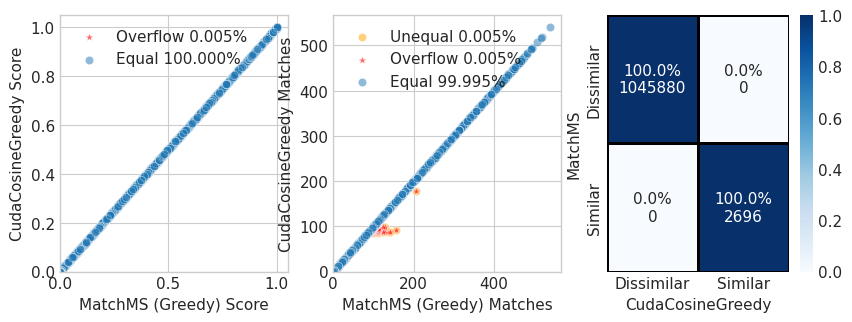

In [6]:
def plot_scatter_diag(
    axis = None,
    scores = scores, 
    scores_cu=scores_cu,
):
    # We use largest batch size for best error estimates
    for ax, key in zip(axis, ['score','matches']):
        a = scores[key].ravel()
        ov = scores_cu['overflow'].ravel() == 1
        b = scores_cu[key].ravel()
        iseq = np.isclose(a,b,atol=.001)
        
        sns.scatterplot(x=a[~iseq],
                        y=b[~iseq], c='orange', alpha=.5, 
                        label=f'Unequal {(~iseq).mean()*100:.3f}%',
                        ax=ax)
        sns.scatterplot(x=a[ov],
                        y=b[ov], marker='*', c='red', 
                        alpha=.6, label=f'Overflow {ov.mean()*100:.3f}%',
                        ax=ax)
        sns.scatterplot(x=a[iseq], y=b[iseq], 
                        alpha=.5, 
                        label=f'Equal {iseq.mean()*100:.3f}%',
                        ax=ax)
        ax.legend(loc='upper left')
        ax.set_xlabel(f"MatchMS (Greedy) {key.capitalize()}")
        ax.set_ylabel(f"CudaCosineGreedy {key.capitalize()}")
        ax.set_ylim([0, None])
        ax.set_xlim([0, None])
        # plt.show()

def plot_heatmap(
    ax = None,
    scores = scores, 
    scores_cu=scores_cu,
):
    # Same thresholds as in BLINK
    a_sim = scores['score'] >= .7 
    b_sim = scores_cu['score'] >= .7
    
    a_sim *= scores['matches'] >= 6
    b_sim *= scores_cu['matches'] >= 6
    
    cm = confusion_matrix(a_sim.ravel(), b_sim.ravel())
    cm_norm = cm / cm.astype(float).sum(axis=0)
    df = pd.DataFrame(cm)
    
    perc = pd.DataFrame(data=cm_norm * 100)
    
    annot = perc.round(2).astype(str) + "%" + "\n" + df.round(2).astype(str) 
    sns.heatmap(cm_norm, annot=annot, fmt='', vmin=0, vmax=1, cmap="Blues", 
                     linewidth=1, linecolor='black', xticklabels=['Dissimilar', 'Similar'], yticklabels=['Dissimilar', 'Similar'], ax=ax)
    ax.set_xlabel('CudaCosineGreedy')
    ax.set_ylabel('MatchMS')

fig, axd = plt.subplot_mosaic(
    [['a','b','c']], 
    figsize=(10,3.33)
)

plot_scatter_diag([axd['a'], axd['b']])
plot_heatmap(axd['c'])

## Tolerance vs performance

In [7]:
np.random.seed(123)

references = np.random.choice(
    spectra, 
    size=int(n_spectra**.5), 
    replace=False, # Just like BLINK, we randomly select without replacement.
)

queries = np.random.choice(
    spectra,
    size=int(n_spectra**.5),
    replace=False,
)

tolerances = np.logspace(
    np.log10(min_tolerance),
    np.log10(max_tolerance), 
    num=num_evals
)

jobs = []
for tolerance in tolerances:
    def loop(tolerance):
        tolerance = float(tolerance) # one of numba's many quirks
        kernel = CosineGreedy(
            tolerance=tolerance
        )
        scores = kernel.matrix(references, queries)
        
        kernel = CudaCosineGreedy(
            tolerance=tolerance,
            batch_size=batch_size,
            verbose=True,
        )
        scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, kernel.kernel_time
    jobs.append(delayed(loop)(tolerance))
    
data = Parallel(4)(jobs)

100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


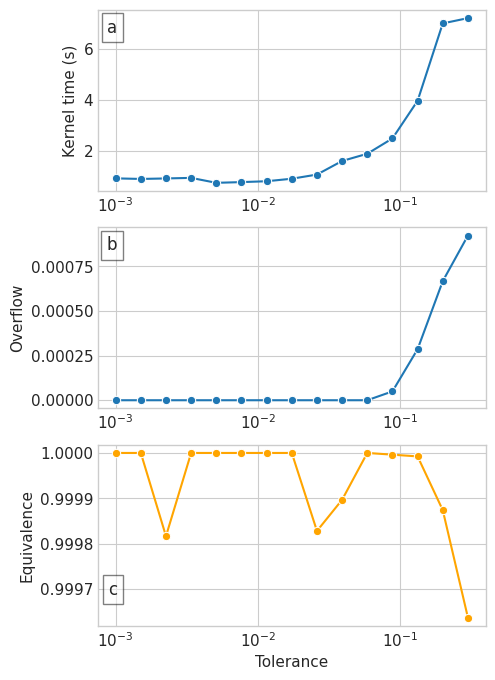

In [8]:
##### We use largest batch size for best error estimates
def plot_tol_and_perf(
    axis = None,
    data = data,
    tolerances=tolerances,
):
    ov_means = []
    match_means = []
    iseq_means = []
    kernel_times = []
    for tolerance, (scores, scores_cu, kernel_time) in zip(tolerances, data):
        a = scores['score'].ravel()
        am = scores['matches'].ravel()
        ov = scores_cu['overflow'].ravel() == 1
        b = scores_cu['score'].ravel()
        bm = scores_cu['matches'].ravel()
        iseq = np.isclose(a,b,atol=.001)
        
        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        kernel_times.append(kernel_time)
    
    # fig, axs = plt.subplot_mosaic(
    #     [['a'], ['b'], ['c']], 
    #     # layout='constrained',
    #     sharex=True,
    #     figsize=(6,6)
    # )
    
    ax = axis[0]
    sns.lineplot(x=tolerances, 
                 y=kernel_times,
                 marker='o',
                 ax=ax)
    ax.text(.05, 0.95, 'a', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    ax.set_ylabel("Kernel time (s)")
    ax.set_xscale('log')
    
    ax = axis[1]
    sns.lineplot(x=tolerances, 
                 y=ov_means,
                 marker='o',
                 ax=ax)
    
    ax.text(.05, 0.95, 'b', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    ax.set_ylabel("Overflow")
    ax.set_xscale('log')
    
    ax = axis[2]
    sns.lineplot(x=tolerances,
                 y=iseq_means, 
                 marker='o',
                 color='orange',
                 ax=ax)
    # thresh_idx = np.searchsorted(iseq_means, .999)
    ax.set_ylabel(r"Equivalence")
    ax.set_xscale('log')
    ax.set_xlabel("Tolerance")
    ax.text(.05, 0.25, 'c', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    

fig, axd = plt.subplot_mosaic(
    [['a'],['b'],['c']], 
    figsize=(5, 8)
)

plot_tol_and_perf(
    axis=[axd[k] for k in 'a b c'.split()], 
)

## Match limit vs performance

In [9]:
np.random.seed(111)

match_limits = np.logspace(
    np.log10(min_match_limit),
    np.log10(max_match_limit), 
    num=num_evals
)
references = np.random.choice(
    spectra, 
    size=int(n_spectra**.5), 
    replace=False, # Just like BLINK, we randomly select without replacement.
)

queries = np.random.choice(
    spectra,
    size=int(n_spectra**.5),
    replace=False,
)

jobs = []
for match_limit in match_limits:
    def loop(match_limit):
        match_limit = int(match_limit) # one of numba's many quirks
        kernel = CosineGreedy()
        scores = kernel.matrix(references, queries)
        kernel = CudaCosineGreedy(
            batch_size=batch_size,
            match_limit=match_limit,
            verbose=True,
        )
        scores_cu = kernel.matrix(references, queries)
        return scores, scores_cu, kernel.kernel_time
    jobs.append(delayed(loop)(match_limit))
data = Parallel(4)(jobs)

100%|██████████| 1/1 [00:09<00:00,  9.92s/it]


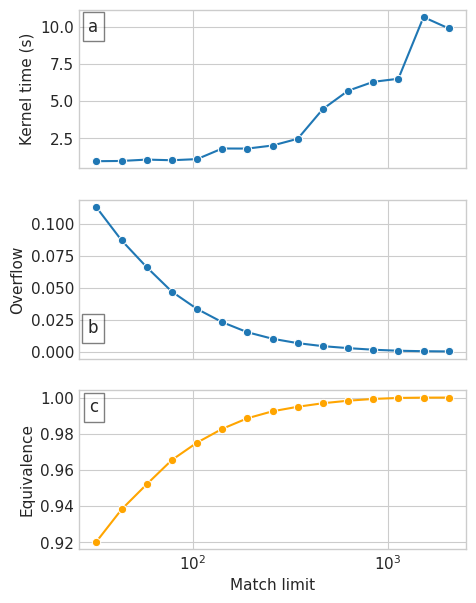

In [10]:
def plot_ml_and_perf(
    axis=None,
    match_limits=match_limits, 
    data=data
):
    ov_means = []
    match_means = []
    iseq_means = []
    kernel_times = []
    for match_limit, (scores, scores_cu, kernel_time) in zip(match_limits, data):
        a = scores['score'].ravel()
        am = scores['matches'].ravel()
        ov = scores_cu['overflow'].ravel() == 1
        b = scores_cu['score'].ravel()
        bm = scores_cu['matches'].ravel()
        iseq = np.isclose(a,b,atol=.001)
        
        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        kernel_times.append(kernel_time)
    
    
    ax = axis[0]
    sns.lineplot(x=match_limits, 
                 y=kernel_times,
                 marker='o',
                 ax=ax)
    ax.text(.05, 0.95, 'a', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    ax.set_ylabel("Kernel time (s)")
    
    ax = axis[1]
    sns.lineplot(x=match_limits, 
                 y=ov_means,
                 marker='o',
                 ax=ax)
    
    ax.text(.05, 0.25, 'b', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    ax.set_ylabel("Overflow")
    
    ax = axis[2]
    sns.lineplot(x=match_limits,
                 y=iseq_means, 
                 marker='o',
                 color='orange',
                 ax=ax)
    # thresh_idx = np.searchsorted(iseq_means, .999)
    ax.set_ylabel(r"Equivalence")

    ax.set_xscale('log')
    ax.set_xlabel("Match limit")
    ax.text(.05, 0.95, 'c', transform=ax.transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.5))
    
fig, axd = plt.subplot_mosaic(
    [['a'],['b'],['c']], 
    figsize=(5, 7),
    sharex=True
)

plot_ml_and_perf(
    axis=[axd[k] for k in 'a b c'.split()], 
)

# Performance plots

Requires us to run notebooks under `notebooks/figures/performance` first.

MatchMS dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
Colab_T4 dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])
RTX4090 dict_keys(['cells', 'metadata', 'nbformat', 'nbformat_minor'])


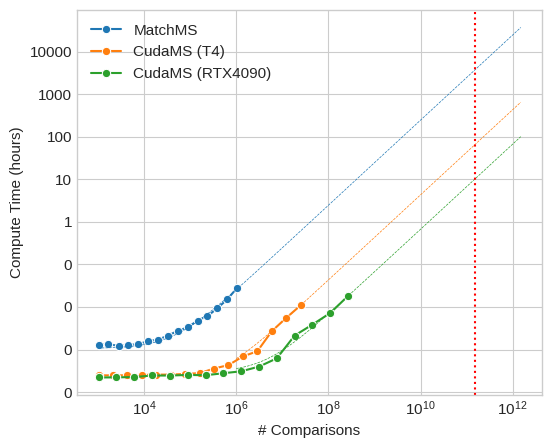

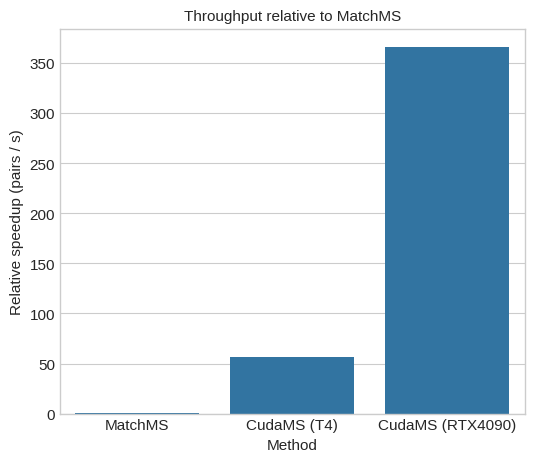

In [43]:
from sklearn.linear_model import LinearRegression
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import numpy as np

data = []
method_mapping = {'matchms': 'MatchMS', 'colab': 'CudaMS (T4)', 'rtx4090': 'CudaMS (RTX4090)'}
for nb in sorted(Path('notebooks/figures/performance/').glob('*.ipynb')):
    method = nb.stem.split('_on_')[-1]
    nb_data = json.loads(nb.read_text())
    print(method, nb_data.keys())
    res = json.loads(' '.join(nb_data['cells'][-1]['outputs'][0]['text']))
    res['method'] = method
    res['pairs'] = res.get('pairs_cu', res.get('pairs'))
    res['times'] = res.get('times_cu', res.get('times'))

    res.pop('pairs_cu', None)
    res.pop('times_cu', None)

    for r in range(len(res['pairs'])):
        if 'cpu' in method:
            res['device'] = 'v32CPU'
        data.append({
            'pairs': res['pairs'][r],
            'times': res['times'][r],
            'device': res['device'],
            'nproc': res['nproc'],
            'method': method
        })

# Since experiments were done in different scales
# to save time,
df = pd.DataFrame(data)
pairs_scale = np.logspace(np.log2(df.pairs.min()), 
                          np.log2(df.pairs.max()),
                          base=2,
                          dtype='float64',
                          num=50)

def plot_perf(ax: plt.Axes, df: pd.DataFrame=df):
    perf_at_axvline = []
    for name in method_mapping:
        gr = df[df['method'].str.lower().str.contains(name)]
        if 'matchms' in name:
            full_range = np.logspace(np.log10(1000), np.log10(100_000 * 1_500_000 * 10), 50).reshape(-1, 1)
        else:
            full_range = np.logspace(np.log10(1_000_000), np.log10(100_000 * 1_500_000 * 10), 50).reshape(-1, 1)

        estimate_next = LinearRegression(positive=True)
        estimate_next.fit(np.array(gr[['pairs']]), np.array(gr[['times']]))
        estim_perf = estimate_next.predict(full_range)

        art = sns.lineplot(x=gr.pairs, 
                           y=gr.times / 3600, 
                           marker='o', label=method_mapping[name])

        sns.lineplot(x=full_range.ravel(), 
                     y=estim_perf.ravel() / 3600, 
                     linestyle='--',
                     linewidth=.5,
                     color=art.lines[-1].get_color())
        goal_num = 100_000 * 1_500_000
        perf_at_axvline.append([method_mapping[name],  goal_num / estimate_next.predict([[goal_num]]).item() ])
    ax.axvline(goal_num, 0, 1, color='red', linestyle=':')
    
    ax.set_xlabel("# Comparisons")
    ax.set_ylabel("Compute Time (hours)")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True, 'major', axis='y')

def plot_perf_at_goal(ax: plt.Axes, df: pd.DataFrame=df):
    perf_at_axvline = []
    gr_matchms = df[df['method'].str.lower().str.contains('matchms')]
    estimate_matchms = LinearRegression(positive=True)
    estimate_matchms.fit(np.array(gr_matchms[['pairs']]), np.array(gr_matchms[['times']]))
    goal_num = 100_000 * 1_500_000
    matchms_speed = (1 / estimate_matchms.predict([[goal_num]]).item())

    for name in method_mapping:
        gr = df[df['method'].str.lower().str.contains(name)]
        estimate = LinearRegression(positive=True)
        estimate.fit(np.array(gr[['pairs']]), np.array(gr[['times']]))
        goal_num = 100_000 * 1_500_000
        speed = (1 / estimate.predict([[goal_num]]).item())
        relative_speedup = speed / matchms_speed
        perf_at_axvline.append([method_mapping[name], relative_speedup])
    
    x, y = zip(*perf_at_axvline)
    sns.barplot(x=x, y=y, ax=ax)
    ax.set_title(f'Throughput relative to MatchMS')
    ax.set_ylabel("Relative speedup (pairs / s)")
    ax.set_xlabel("Method")

    ax.grid(True, 'major', axis='y')

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_perf(ax)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_perf_at_goal(ax)
plt.show()

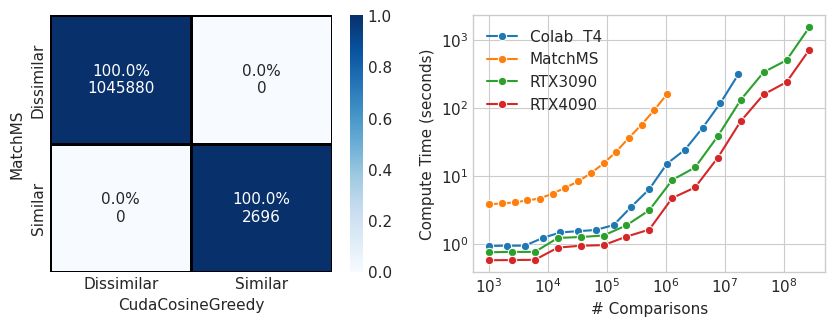

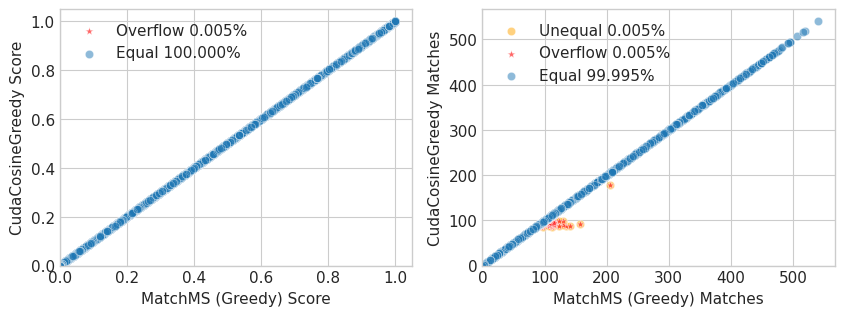

In [12]:
## Heatmap + Perf graph plot (analogue to fig 1 in BLINK)
fig, axd = plt.subplot_mosaic(
    [['a','b']], 
    figsize=(10,3.33)
)
plot_heatmap(axd['a'])
plot_perf(axd['b'])

# Scatter of error, analogue to fig 2 
fig, axd = plt.subplot_mosaic(
    [['a','b']],
    figsize=(10,3.33)
)
plot_scatter_diag([axd['a'], axd['b']])

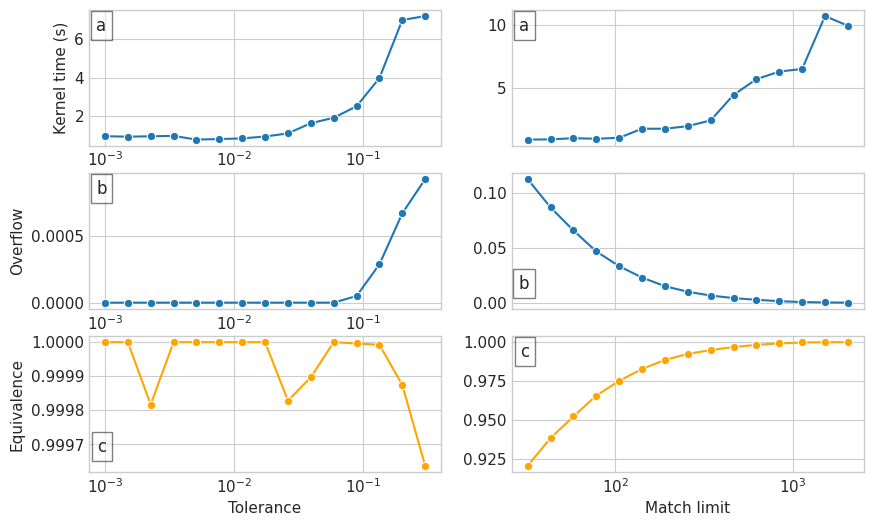

In [13]:
## Fig 3 equivalents, but two, one for tolerance, other for match limit
# Tolerance
fig, axd = plt.subplot_mosaic(
    [['a','A'],
     ['b','B'],
     ['c','C']], 
    figsize=(10,6),
)
plot_tol_and_perf(
    axis=[axd[k] for k in 'a b c'.split()], 
)

# match limit
plot_ml_and_perf(
    axis=[axd[k] for k in 'A B C'.split()], 
)
[axd[k].set_ylabel(None) for k in 'A B C'.split()];
[axd[k].set_xscale('log') for k in 'A B'.split()];
[axd[k].set_xticklabels([]) for k in 'A B'.split()];